In [ ]:
# Продолжайте развитие и анализ сгененированных данных.
# 4.1. На выбор, реализация текстурных характеристик:
#  - Признаки Тамура
#  - матрица взаимной встречаемости
# 4.2. На выбор, реализация алгоритма сегментации при помощи выбранного алгоритма кластеризации данных:
# https://scikit-learn.ru/stable/modules/clustering.html
# 4.2.1 Если в кодировке пикселя не использовали его положение, выделите связные регионы.
# 4.3. На выбор, рассчитайте Качество проведенной сегментации на основе характеристик качества кластеризации:
# https://scikit-learn.ru/stable/modules/clustering.html#clustering-evaluation
# 4.4. Визуализируйте результат сегментации
# 4.5 Рассчитайте характеристики(описание формы) объектов.
# 4.6 Используя алгоритм кластеризации, найдите количество классов объектов на изображении.

Генератор

In [1]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

def load_patches_from_folder(folder_path):

    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background_from_patches(background_patches, num_patches=8, output_size=(256, 256)):

    selected_patches = random.choices(background_patches, k=num_patches)
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
    patch_size = 128

    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            if selected_patches:
                patch = selected_patches.pop()

                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = cv2.resize(patch, (patch_size, patch_size))

                try:
                    background[i:i+patch_size, j:j+patch_size] = patch
                except ValueError as e:
                    print(f"Ошибка при размещении патча: {e}")
                    continue
            else:
                break

    return background

def overlay_cells_on_background(background, cell_patches, num_cells=5):

    output = background.copy()
    for _ in range(num_cells):

        cell = random.choice(cell_patches)
        x = random.randint(0, background.shape[0] - cell.shape[0])
        y = random.randint(0, background.shape[1] - cell.shape[1])
        mask = np.zeros((cell.shape[0], cell.shape[1], 3), dtype=np.uint8)
        radius = min(cell.shape[0], cell.shape[1]) // 2
        cv2.circle(mask, (cell.shape[1] // 2, cell.shape[0] // 2), radius, (255, 255, 255), -1)
        mask = cv2.GaussianBlur(mask, (51, 51), 0)
        mask = mask.astype(np.float32) / 255.0

        for c in range(3):
            output[x:x+cell.shape[0], y:y+cell.shape[1], c] = (
                output[x:x+cell.shape[0], y:y+cell.shape[1], c] * (1 - mask[:, :, c]) +
                cell[:, :, c] * mask[:, :, c]
            )
    return output

patches_folder = '/content/patches'
background_folder = os.path.join(patches_folder, 'background')
cells_folder = os.path.join(patches_folder, 'cells')

background_patches = load_patches_from_folder(background_folder)
cell_patches = load_patches_from_folder(cells_folder)

4.1 Признаки Тамура

Признаки Тамура: {'contrast': np.float64(0.22990658887681567), 'directionality': np.float64(0.18417829144015138), 'coarseness': np.float64(0.7664073838477042)}


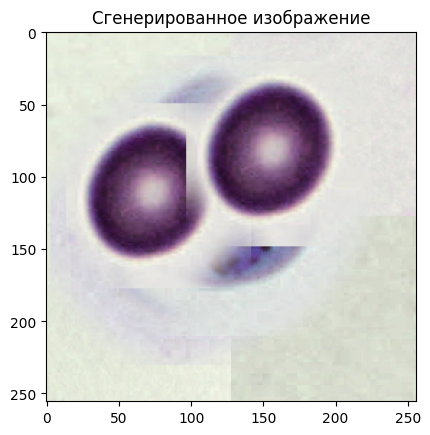

In [29]:
from skimage import color
def compute_tamura_features(image):
    gray_image = color.rgb2gray(image)

    contrast = np.std(gray_image)

    grad_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    directionality = np.std(magnitude)

    coarseness = np.mean(gray_image)

    return {
        'contrast': contrast,
        'directionality': directionality,
        'coarseness': coarseness
    }

background = generate_background_from_patches(background_patches)
output_image = overlay_cells_on_background(background, cell_patches)

tamura_features = compute_tamura_features(output_image)
print("Признаки Тамура:", tamura_features)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Сгенерированное изображение")
plt.show()

4.2 KMeans

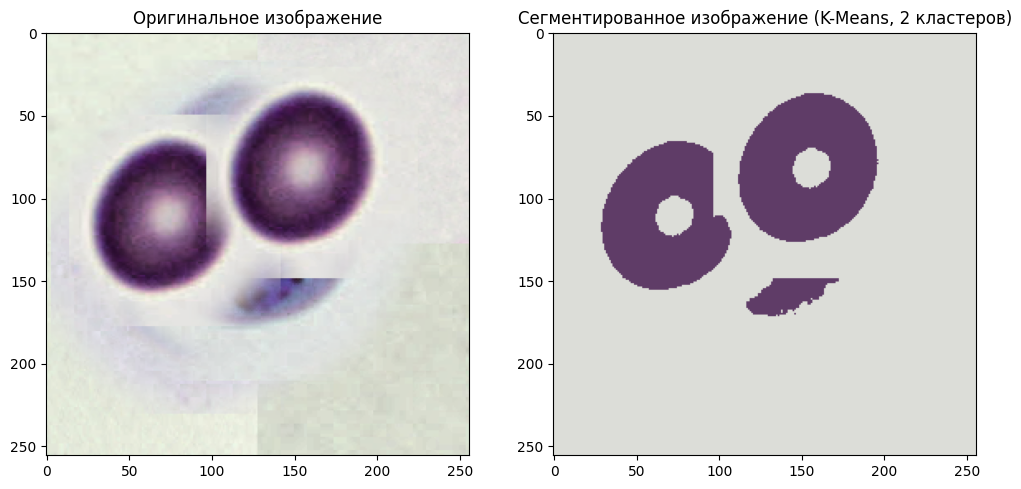

In [30]:
from sklearn.cluster import KMeans

def segment_image_kmeans(image, n_clusters=3):

    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixel_values)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    centers = np.uint8(centers)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image, labels.reshape(image.shape[:2])


n_clusters = 2
segmented_image, labels = segment_image_kmeans(output_image, n_clusters=n_clusters)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Оригинальное изображение")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f"Сегментированное изображение (K-Means, {n_clusters} кластеров)")

plt.show()

4.3 Коэффициент силуэта, Индекс Дэвиса-Булдина

In [31]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_segmentation(image, labels):
    pixel_values = image.reshape((-1, 3))

    silhouette_avg = silhouette_score(pixel_values, labels.flatten())
    davies_bouldin = davies_bouldin_score(pixel_values, labels.flatten())

    return {
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': davies_bouldin
    }

evaluation_metrics = evaluate_segmentation(output_image, labels)

print("Метрики качества сегментации:")
print(f"Silhouette Score: {evaluation_metrics['silhouette_score']:.4f}")
print(f"Davies-Bouldin Index: {evaluation_metrics['davies_bouldin_index']:.4f}")

Метрики качества сегментации:
Silhouette Score: 0.8556
Davies-Bouldin Index: 0.2816


4.5

Объект 1:
  Площадь: 54258.0
  Периметр: 1725.4112549695428
  Эксцентриситет: 0.1462
  Компактность: 0.0182
  Ориентация: 0.2183
  Центроид: (np.float64(133.42471156327179), np.float64(130.32916804895132))

Объект 2:
  Площадь: 594.0
  Периметр: 94.49747468305833
  Эксцентриситет: 0.3688
  Компактность: 0.0665
  Ориентация: -0.6891
  Центроид: (np.float64(81.85858585858585), np.float64(156.04545454545453))

Объект 3:
  Площадь: 594.0
  Периметр: 94.49747468305833
  Эксцентриситет: 0.3688
  Компактность: 0.0665
  Ориентация: -0.6891
  Центроид: (np.float64(110.85858585858585), np.float64(73.04545454545455))



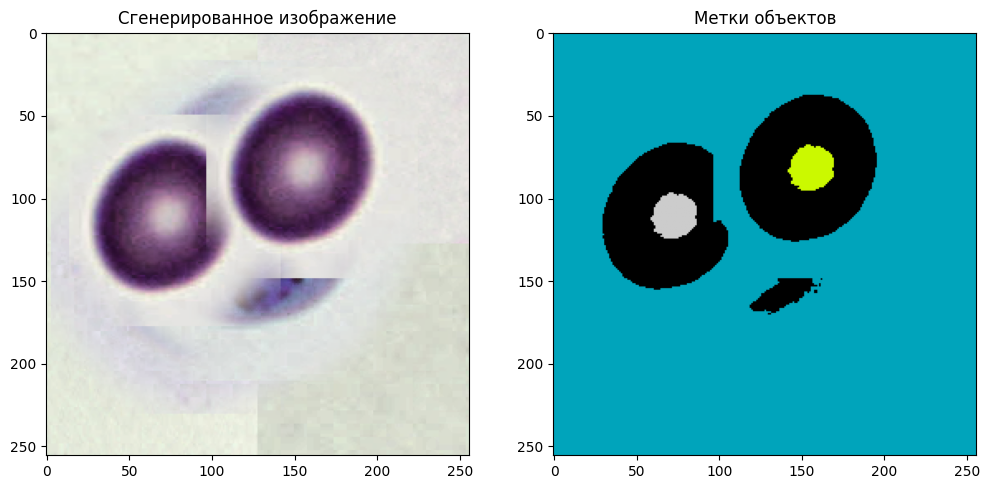

In [33]:
from skimage.measure import label, regionprops
from skimage import measure

def analyze_object_properties(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    labeled_image = label(binary_image)
    regions = regionprops(labeled_image)

    for i, region in enumerate(regions):
        print(f"Объект {i + 1}:")
        print(f"  Площадь: {region.area}")
        print(f"  Периметр: {region.perimeter}")
        print(f"  Эксцентриситет: {region.eccentricity:.4f}")
        print(f"  Компактность: {(region.area / (region.perimeter ** 2)):.4f}")
        print(f"  Ориентация: {region.orientation:.4f}")
        print(f"  Центроид: {region.centroid}")
        print()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Сгенерированное изображение")

    plt.subplot(1, 2, 2)
    plt.imshow(labeled_image, cmap='nipy_spectral')
    plt.title("Метки объектов")
    plt.show()

analyze_object_properties(output_image)

4.6

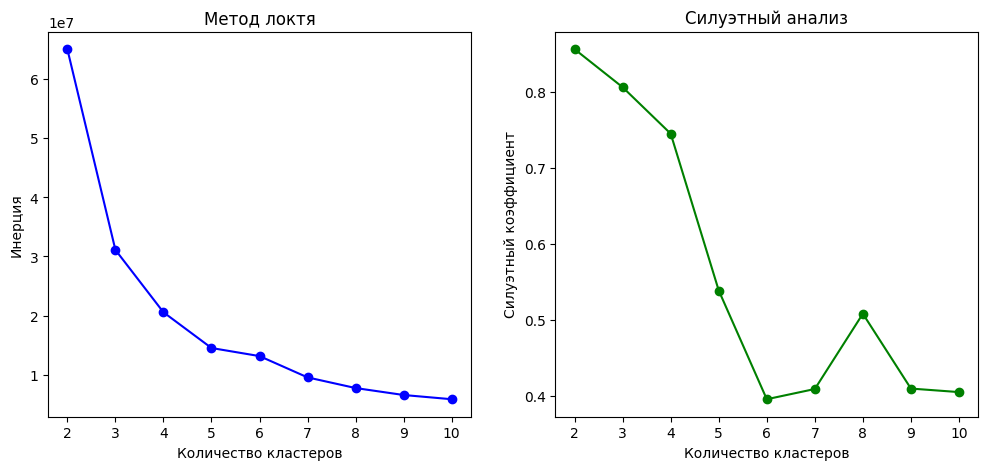

Оптимальное количество кластеров: 2


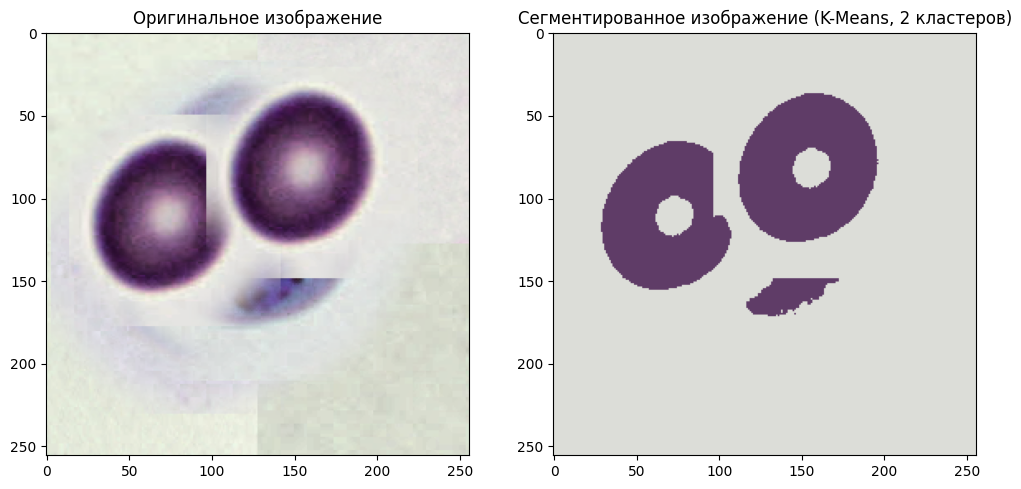

In [34]:
def find_optimal_clusters(image, max_clusters=10):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    distortions = []
    K = range(2, max_clusters + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        distortions.append(kmeans.inertia_)

    silhouette_scores = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(pixel_values)
        silhouette_scores.append(silhouette_score(pixel_values, labels))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')
    plt.title('Метод локтя')

    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'go-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Силуэтный коэффициент')
    plt.title('Силуэтный анализ')

    plt.show()

    optimal_k = K[np.argmax(silhouette_scores)]
    print(f"Оптимальное количество кластеров: {optimal_k}")

    return optimal_k

def apply_kmeans(image, n_clusters):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixel_values)
    centers = kmeans.cluster_centers_

    centers = np.uint8(centers)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image, labels.reshape(image.shape[:2])

optimal_clusters = find_optimal_clusters(output_image, max_clusters=10)

segmented_image, labels = apply_kmeans(output_image, optimal_clusters)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Оригинальное изображение")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f"Сегментированное изображение (K-Means, {optimal_clusters} кластеров)")

plt.show()